

# Class Imbalance Experiments

This notebook explores strategies to correct for class imbalance in the Financial PhraseBank dataset—particularly the overrepresentation of Neutral labels and the underperformance on Negative sentiment. The imbalance is especially pronounced in short sentences, where Neutral dominates.

The goal is to test whether reweighting techniques—both static and length-aware—can improve macro-averaged performance and minority-class recall without degrading overall accuracy. These adjustments focus specifically on modifying the training dynamics of the classification head.

## Summary of Results

| Experiment                                | Test Accuracy | Macro F1 | Negative Recall | Positive Recall | Notes                                                     |
| ----------------------------------------- | ------------- | -------- | --------------- | --------------- | --------------------------------------------------------- |
| Benchmark (No Weighting)                  | 0.8590        | 0.74     | 0.37            | 0.84            | Baseline with frozen encoder                              |
| Static Class Weights                      | 0.8414        | 0.67     | 0.20            | 0.82            | Simple inverse-frequency weighting                        |
| Dynamic Class Weights (Token Length Bins) | 0.8771        | 0.81     | 0.57            | 0.89            | Token-length-aware weighting improves recall and macro-F1 |

## Experiment Roadmap

1. **Benchmark Reproduction** — Baseline model with no weighting
2. **Static Weighting** — Global class weights based on inverse label frequency
3. **Dynamic Weighting** — Class weights adjusted per token-length bin

The dynamic weighting strategy outperformed others across key metrics and will serve as the new default approach moving forward.


# Loading Up to 3.1 Benchmark

In [ ]:
# Install required libraries
!pip install -q transformers datasets scikit-learn pandas numpy tqdm tensorflow

# Imports
import os
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

from tqdm import tqdm
from collections import Counter, defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    TFDistilBertModel,
    TFAutoModelForSequenceClassification,
    DataCollatorWithPadding
)

# Suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = load_dataset("financial_phrasebank", "sentences_allagree") 

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=256  
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train_dataset = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_validation_dataset = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test_dataset = to_tf_dataset(val_test_split["test"], shuffle=False)

model = TFAutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3
)

model.distilbert.trainable = False  

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 15s 76ms/step - loss: 0.5791 - accuracy: 0.7350 - val_loss: 0.4317 - val_accuracy: 0.7920
Epoch 2/3
114/114 [==============================] - 7s 62ms/step - loss: 0.3899 - accuracy: 0.8310 - val_loss: 0.4010 - val_accuracy: 0.8274
Epoch 3/3
15/15 [==============================] - 1s 46ms/step - loss: 0.3417 - accuracy: 0.8546
Test Loss: 0.3417, Test Accuracy: 0.8546


## 2. Static Class Weighting

Applies inverse class frequency weights based on the training set to reduce bias toward the overrepresented Neutral class. Each class is weighted by the inverse of its occurrence, so rarer classes (e.g., Negative) contribute more to the loss, encouraging balanced learning.

Class Weights: {0: np.float64(2.6246376811594203), 1: np.float64(0.5433543354335434), 2: np.float64(1.2843971631205673)}


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 16s 76ms/step - loss: 0.5831 - accuracy: 0.7526 - val_loss: 0.5071 - val_accuracy: 0.8097
Epoch 2/3
114/114 [==============================] - 7s 62ms/step - loss: 0.4104 - accuracy: 0.8283 - val_loss: 0.4633 - val_accuracy: 0.8097
Epoch 3/3
15/15 [==============================] - 1s 45ms/step - loss: 0.3737 - accuracy: 0.8414
Test Loss: 0.3737, Test Accuracy: 0.8414


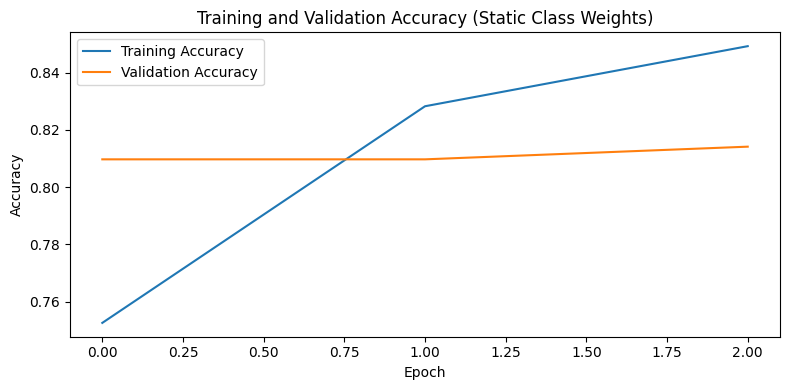

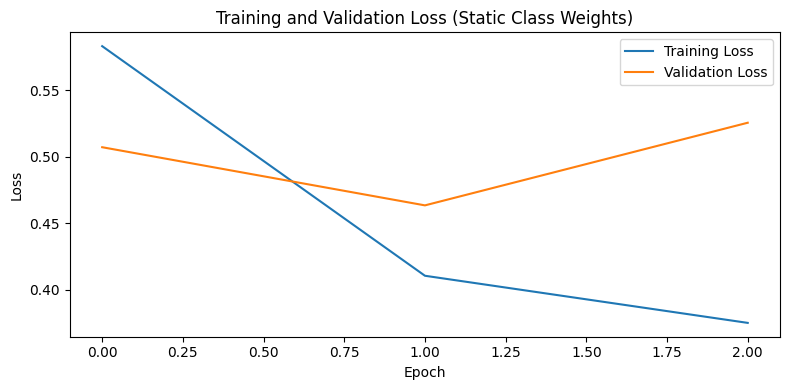

15/15 [==============================] - 2s 44ms/step
              precision    recall  f1-score   support

    Negative       0.86      0.20      0.32        30
     Neutral       0.96      0.96      0.96       142
    Positive       0.63      0.89      0.74        55

    accuracy                           0.84       227
   macro avg       0.81      0.68      0.67       227
weighted avg       0.86      0.84      0.82       227



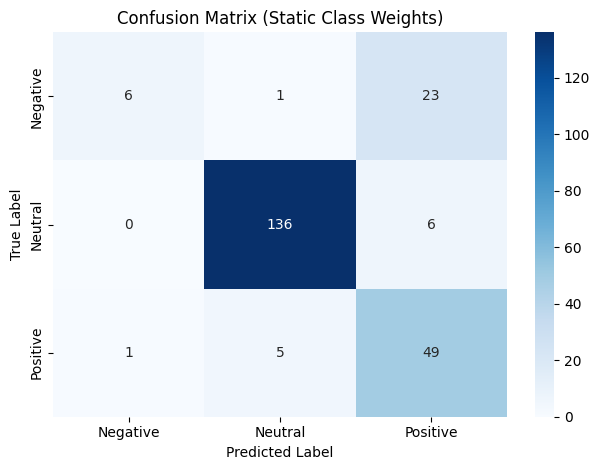

In [ ]:

train_labels = [example['label'] for example in train_val_split['train']]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
model.distilbert.trainable = False

def weighted_loss(y_true, y_pred):
    weights = tf.gather(
        tf.constant([class_weight_dict[i] for i in range(3)], dtype=tf.float32),
        tf.cast(y_true, tf.int32)
    )
    unweighted_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    return tf.reduce_mean(unweighted_loss * weights)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=weighted_loss, metrics=["accuracy"])

history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=3
)

eval_loss, eval_accuracy = model.evaluate(tf_test_dataset)
print(f"Test Loss: {eval_loss:.4f}, Test Accuracy: {eval_accuracy:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy (Static Class Weights)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Step 8: Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss (Static Class Weights)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

y_pred_logits = model.predict(tf_test_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test_dataset], axis=0)

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Static Class Weights)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

### Static Class Weighting Results

Static inverse-frequency weighting slightly reduced test accuracy (85.9% → 84.1%) and macro F1 (0.74 → 0.67), with no improvement in Negative class recall (down from 0.37 to 0.20). Most Negative samples were still misclassified as Positive, while Neutral and Positive classes remained largely unaffected.

These results suggest static weighting alone is not sufficient to correct for label imbalance and may even introduce instability. More adaptive or context-sensitive strategies are needed.


---

## 3. Dynamic Class Weighting Based on Token Length

Rather than applying uniform class weights, this experiment adjusts class weighting based on input token length. Exploratory analysis showed that shorter sentences are overwhelmingly Neutral, while longer ones are more sentiment-rich and balanced.

To capture this, the training data is split into quantile-based length bins (short, medium, long). For each bin, inverse-frequency class weights are computed and applied dynamically at training time, depending on the sentence length.

This approach allows the model to adapt its bias correction based on context, improving sensitivity to underrepresented classes where they are most underrepresented.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/3
114/114 [==============================] - 15s 77ms/step - loss: 0.5701 - accuracy: 0.7011 - val_loss: 0.0107 - val_accuracy: 0.8230
Epoch 2/3
114/114 [==============================] - 7s 62ms/step - loss: 0.3999 - accuracy: 0.8054 - val_loss: 0.4498 - val_accuracy: 0.8407
Epoch 3/3
15/15 [==============================] - 3s 46ms/step

Test Accuracy: 0.8767
              precision    recall  f1-score   support

    Negative       0.94      0.57      0.71        30
     Neutral       0.96      0.94      0.95       142
    Positive       0.70      0.89      0.78        55

    accuracy                           0.88       227
   macro avg       0.87      0.80      0.81       227
weighted avg       0.89      0.88      0.88       227



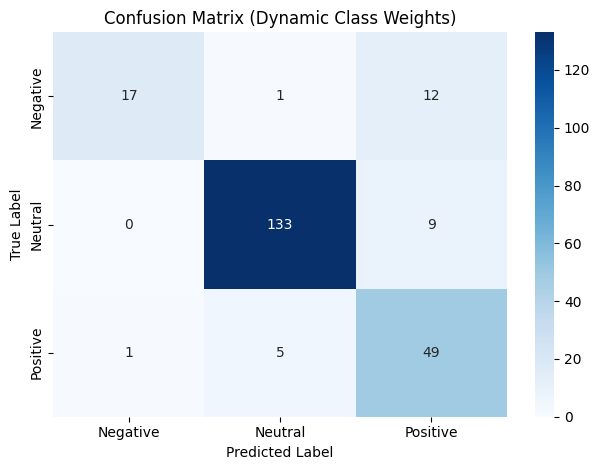

In [ ]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
dataset = load_dataset("financial_phrasebank", "sentences_allagree")

def compute_length_and_bin(example):
    length = len(tokenizer.tokenize(example["sentence"]))
    example["token_length"] = length
    return example

dataset = dataset.map(compute_length_and_bin)

# Compute quantiles and bin edges from training set
lengths = dataset["train"]["token_length"]
q1, q2 = np.percentile(lengths, [33, 66])

def assign_bin(example):
    length = example["token_length"]
    if length <= q1:
        example["bin_index"] = 0  # short
    elif length <= q2:
        example["bin_index"] = 1  # medium
    else:
        example["bin_index"] = 2  # long
    return example

dataset = dataset.map(assign_bin)

def tokenize_with_bin(example):
    tokens = tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=256)
    tokens["label"] = example["label"]
    tokens["bin_index"] = example["bin_index"]
    return tokens

tokenized_datasets = dataset.map(tokenize_with_bin, batched=True)

train_val_split = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split["test"].train_test_split(test_size=0.5, seed=42)

bin_class_counts = defaultdict(Counter)
for i in range(len(train_val_split["train"])):
    row = train_val_split["train"][i]
    bin_class_counts[row["bin_index"]][row["label"]] += 1

weight_matrix = np.zeros((3, 3))
for bin_id, class_counts in bin_class_counts.items():
    total = sum(class_counts.values())
    for cls, count in class_counts.items():
        weight_matrix[bin_id][cls] = total / (len(class_counts) * count)

weight_tensor = tf.constant(weight_matrix, dtype=tf.float32)

def to_tf_dataset(split, shuffle=False):
    return split.to_tf_dataset(
        columns=["input_ids", "attention_mask", "bin_index"],
        label_cols=["label"],
        shuffle=shuffle,
        batch_size=16,
        collate_fn=None
    )

tf_train = to_tf_dataset(train_val_split["train"], shuffle=True)
tf_val = to_tf_dataset(val_test_split["train"], shuffle=True)
tf_test = to_tf_dataset(val_test_split["test"], shuffle=False)

# Custom model with dynamic loss
class CustomDistilBERT(tf.keras.Model):
    def __init__(self, base_model, weight_tensor):
        super().__init__()
        self.model = base_model
        self.weight_tensor = weight_tensor

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metric_fn = tf.keras.metrics.SparseCategoricalAccuracy()

    def train_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True).logits
            weights = tf.gather_nd(
              self.weight_tensor,
              tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
              )
            loss = self.loss_fn(y_true, logits)
            weighted_loss = tf.reduce_mean(loss * weights)
        grads = tape.gradient(weighted_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def test_step(self, batch):
        x, y_true = batch
        bin_index = x.pop("bin_index")
        logits = self.model(x, training=False).logits
        weights = tf.gather_nd(
              self.weight_tensor,
              tf.stack([tf.cast(bin_index, tf.int32), tf.cast(y_true, tf.int32)], axis=1)
              )
        loss = self.loss_fn(y_true, logits)
        weighted_loss = tf.reduce_mean(loss * weights)
        self.metric_fn.update_state(y_true, logits)
        return {"loss": weighted_loss, "accuracy": self.metric_fn.result()}

    def call(self, inputs):
      inputs = inputs.copy()  # Prevent modifying original dict
      inputs.pop("bin_index", None)
      return self.model(inputs)


base_model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)
base_model.distilbert.trainable = False

model = CustomDistilBERT(base_model, weight_tensor)
model.compile(optimizer=tf.keras.optimizers.Adam())

history = model.fit(tf_train, validation_data=tf_val, epochs=3)

logits = model.predict(tf_test).logits
y_pred = np.argmax(logits, axis=1)
y_true = np.concatenate([y for _, y in tf_test], axis=0)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix (Dynamic Class Weights)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()



### Dynamic Class Weighting Results

Token-length-aware weighting improved performance across key metrics. Test accuracy rose to **87.7%**, and the macro F1 score increased to 0.81. Most notably, Negative class recall jumped from 0.20 (static) to 0.57, showing stronger recognition of the minority class.

The confusion matrix shows fewer misclassifications of Negative examples, while Neutral and Positive classes remained stable. These results confirm that context-sensitive weighting—tailored to input length—can address structural imbalance more effectively than static methods.


Continuation back in [Main Notebook](../part1_finetuning_Distilbert.ipynb)